# Sea Ice example notebook for timeseries

---

This notebook shows how to use the seaice diagnostic. It contains an example of access of a reference (OSI-SAF or PSC) and model (IFS-NEMO) datasets to evaluate 
and plot the sea ice extension, volume, fraction and thickness variables.

The only import needed is the `SeaIce` and `PlotSeaIce` and `Plot2DSeaIce` classes from the `aqua.diagnostics` module.

In [1]:
from aqua.diagnostics import SeaIce, PlotSeaIce, Plot2DSeaIce

/LUMI_TYKKY_Z6kXmtP/miniforge/envs/env1/lib/python3.12/site-packages/intake_esm/__init__.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


- The `SeaIce` class allow to retrive, regrid and perform the main analysis on the data. It also allow to save the resulting data as NetCDF file (through the method `save_netcdf`). 
- The `PlotSeaIce` class allow to plot and evaluate the `extent` and `volume` of sea ice.
- The `Plot2DSeaIce` class allow to plot 2D maps and evaluate the differences of `fraction` and `thickness` of sea ice.

## Data retrieve and sea ice calculation

At first it must be initialised the class `SeaIce`, which calls internally the `Reader` and performs the regridding (if a `regrid` option is provided).  
Then we compute the sea ice for the model data (using the method `compute_seaice`).  
The `regions` argument allow to choose the specific regions defined by lat-lon in `regions.yaml` file. 

## Seaice extent

### Calculate: model data surface extent 

In [2]:
method   = 'extent'   # This is the method we want to compute with the seaice data
varname  = 'siconc'   # This is the right variable name relative to the desired method for IFS-NEMO
source   = 'lra-r100-monthly' # source name can change depending on the model and exp
regions_domain = ['arctic','antarctic']
regrid='r100'
loglevel = 'info'

seaice_model = SeaIce(model='IFS-NEMO', exp='historical-1990', source=source, regions=regions_domain, 
                      startdate='1991-01-01', enddate='2000-01-01', 
                      regrid=regrid, loglevel='info')
simod = seaice_model.compute_seaice(method=method, var=varname)

2025-09-19 10:59:21 :: ConfigPath :: INFO     -> IFS-NEMO_historical-1990_lra-r100-monthly triplet found in in climatedt-phase1!
2025-09-19 10:59:22 :: Fixer :: INFO     -> Convention dictionary: eccodes-2.39.0
2025-09-19 10:59:22 :: Fixer :: INFO     -> No fixer_name found, only convention will be applied
2025-09-19 10:59:22 :: Reader :: INFO     -> Grid metadata is lon-lat
2025-09-19 10:59:22 :: Regridder :: WARNING  -> Source grid path not found. Please provide a dataset.
2025-09-19 10:59:22 :: Reader :: WARNING  -> Issues in the Regridder() init: trying with data
2025-09-19 10:59:48 | smmregrid.GridInspect |     INFO -> Data is already an xarray Dataset or DataArray
2025-09-19 10:59:48 | smmregrid.GridInspect |     INFO -> Updating the log_level to INFO
2025-09-19 10:59:48 | smmregrid.GridInspect |     INFO -> Data is already an xarray Dataset or DataArray
2025-09-19 10:59:48 :: Regridder :: INFO     -> Using provided dataset as a grid path for 2d
2025-09-19 10:59:48 :: Regridder :

- The data can be saved into NetCDF files:

In [ ]:
seaice_model.save_netcdf(simod, 'seaice', diagnostic_product='timeseries', extra_keys={'method': method, 'source': source, 'regions_domain': "_".join(regions_domain)})

### Calculate: reference sea ice surface extent 

The same steps must be applied to the observations (reference data). Since we want to plot both the Arctic and Antarctic regions, we need to load the Northern   
and Southern Hemisphere data separately, as OSI-SAF provides these datasets individually. To enable a fairer comparison of model performance against observations,   
the reference sea ice extent standard deviation can be calculated, so set `calc_std_freq='monthly'` to generate the additional datasets with the standard deviation computed from the data.  
At present, only monthly time series plotting is supported for sea ice.  


In [ ]:
seaice_ref_nh = SeaIce(model='OSI-SAF', exp='osi-saf-aqua', source='nh-monthly', regions='arctic',
                       startdate='1991-01-01', enddate='2000-01-01', 
                       regrid=regrid, loglevel=loglevel)
si_ref_nh, si_std_ref_nh = seaice_ref_nh.compute_seaice(method=method, var=varname, calc_std_freq='monthly')

seaice_ref_sh = SeaIce(model='OSI-SAF', exp='osi-saf-aqua', source='sh-monthly', regions='antarctic',
                      startdate='1991-01-01', enddate='2000-01-01', 
                      regrid=regrid, loglevel=loglevel)
si_ref_sh, si_std_ref_sh = seaice_ref_sh.compute_seaice(method=method, var=varname, calc_std_freq='monthly')

2025-09-19 10:59:50 :: ConfigPath :: INFO     -> OSI-SAF_osi-450_nh-monthly triplet found in in obs!
2025-09-19 10:59:51 :: Fixer :: INFO     -> Convention dictionary: eccodes-2.39.0
2025-09-19 10:59:51 :: Fixer :: INFO     -> Fix names in metadata is OSI-SAF-default
2025-09-19 10:59:51 :: Fixer :: INFO     -> Fix names OSI-SAF-default found in fixes files
2025-09-19 10:59:51 :: Reader :: INFO     -> Grid metadata is osi-saf-nh
2025-09-19 10:59:51 :: Regridder :: INFO     -> Grid name: osi-saf-nh
2025-09-19 10:59:51 :: Regridder :: INFO     -> Loading existing source area from /pfs/lustrep3/appl/local/climatedt/data/AQUA/areas/cell_area_osi-saf-nh.nc.
2025-09-19 10:59:51 :: CoordIdentifier :: WARNING  -> Multiple latitude coordinates found: ['lat', 'yc']. Disabling data model check for this coordinate.
2025-09-19 10:59:51 :: CoordIdentifier :: WARNING  -> Multiple longitude coordinates found: ['lon', 'xc']. Disabling data model check for this coordinate.
2025-09-19 10:59:51 :: CoordTra

Following example above, the data can be saved in NetCDF.

### Plot: surface extent for reference and model

To plot the seaice timeseries, we first instantiate the `PlotSeaIce` object and then plot it with the `plot_seaice` method.

- The `plot_seaice` method accepts a single xr.DataArray, a xr.Dataset or a list of xr.Dataset.  
Switch *save_pdf* *_png* to *True* to save the figure in the selected *outputdir*:

2025-09-19 10:59:54 :: PlotSeaIce :: INFO     -> Sea ice data repacked
2025-09-19 10:59:54 :: PlotSeaIce :: INFO     -> Plotting sea ice timeseries
2025-09-19 10:59:54 :: PlotSeaIce :: INFO     -> Processing method: extent
2025-09-19 10:59:56 :: PlotSeaIce :: INFO     -> Processing timeseries for region: Arctic
2025-09-19 10:59:56 :: PlotSeaIce :: INFO     -> Returning 'None' for key: annual_models
2025-09-19 10:59:56 :: PlotSeaIce :: INFO     -> Returning 'None' for key: annual_ref
2025-09-19 10:59:56 :: PlotSeaIce :: INFO     -> Returning 'None' for key: annual_std_ref
2025-09-19 11:00:05 :: PlotSeaIce :: INFO     -> Processing timeseries for region: Antarctic
2025-09-19 11:00:05 :: PlotSeaIce :: INFO     -> Returning 'None' for key: annual_models
2025-09-19 11:00:05 :: PlotSeaIce :: INFO     -> Returning 'None' for key: annual_ref
2025-09-19 11:00:05 :: PlotSeaIce :: INFO     -> Returning 'None' for key: annual_std_ref
2025-09-19 11:00:10 :: PlotSeaIce :: INFO     -> Plotting of all

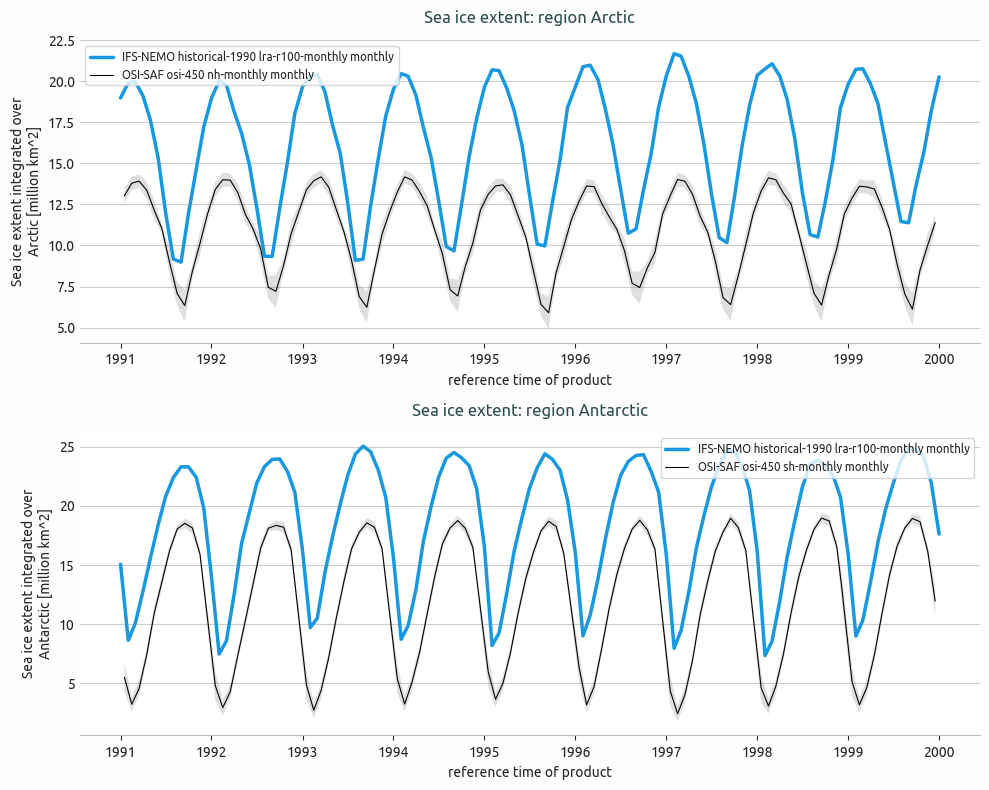

In [4]:
psi = PlotSeaIce(monthly_models=simod,
                 monthly_ref=[si_ref_nh, si_ref_sh],
                 monthly_std_ref=[si_std_ref_nh, si_std_ref_sh], 
                 outputdir='.',
                 rebuild=True,
                 loglevel=loglevel)
psi.plot_seaice(plot_type='timeseries', save_pdf=False, save_png=False)

---

## Seaice volume 

Similar steps as above must be followed for the computation of the integrated volume.

### Calculate: model data sea ice volume

In [ ]:
method   = 'volume'    # This is the method we want to compute with the seaice data
varname  = 'sithick'   # This is the right variable name relative to the desired method for IFS-NEMO
source   = 'lra-r100-monthly'
regions_domain = ['arctic','antarctic']
regrid='r100'
loglevel = 'info'

seaice_model = SeaIce(model='IFS-NEMO', exp='historical-1990', source=source, regions=regions_domain,
                      startdate='1991-01-01', enddate='2000-01-01',
                      regrid=regrid, loglevel='info')
simod = seaice_model.compute_seaice(method=method, var=varname)

### Calculate: reference sea ice volume 

In [ ]:
varname = 'sivol'

seaice_ref_nh = SeaIce(model='PSC', exp='PIOMAS', source='monthly', regions='arctic',
                       startdate='1991-01-01', enddate='2000-01-01',
                       regrid=regrid, loglevel=loglevel)
si_ref_nh, si_std_ref_nh = seaice_ref_nh.compute_seaice(method=method, var=varname, calc_std_freq='monthly')

seaice_ref_sh = SeaIce(model='PSC', exp='GIOMAS', source='monthly', regions='antarctic',
                       startdate='1991-01-01', enddate='2000-01-01', 
                       regrid=regrid, loglevel=loglevel)
si_ref_sh, si_std_ref_sh = seaice_ref_sh.compute_seaice(method=method, var=varname, calc_std_freq='monthly')

### Plot: sea ice volume for reference and model

To plot the seaice timeseries, we first instantiate the `PlotSeaIce` object and then plot it with the `plot_seaice` method.

- The `plot_seaice` method accepts a single xr.DataArray, a xr.Dataset or a list of xr.Dataset.  
Switch *save_pdf* *_png* to *True* to save the figure in the selected *outputdir*:

2025-09-19 11:00:33 :: PlotSeaIce :: INFO     -> Sea ice data repacked
2025-09-19 11:00:33 :: PlotSeaIce :: INFO     -> Plotting sea ice timeseries
2025-09-19 11:00:33 :: PlotSeaIce :: INFO     -> Processing method: volume
2025-09-19 11:00:33 :: PlotSeaIce :: INFO     -> Processing timeseries for region: Arctic
2025-09-19 11:00:33 :: PlotSeaIce :: INFO     -> Returning 'None' for key: annual_models
2025-09-19 11:00:33 :: PlotSeaIce :: INFO     -> Returning 'None' for key: annual_ref
2025-09-19 11:00:33 :: PlotSeaIce :: INFO     -> Returning 'None' for key: annual_std_ref
2025-09-19 11:00:42 :: PlotSeaIce :: INFO     -> Processing timeseries for region: Antarctic
2025-09-19 11:00:42 :: PlotSeaIce :: INFO     -> Returning 'None' for key: annual_models
2025-09-19 11:00:42 :: PlotSeaIce :: INFO     -> Returning 'None' for key: annual_ref
2025-09-19 11:00:42 :: PlotSeaIce :: INFO     -> Returning 'None' for key: annual_std_ref
2025-09-19 11:00:52 :: PlotSeaIce :: INFO     -> Plotting of all

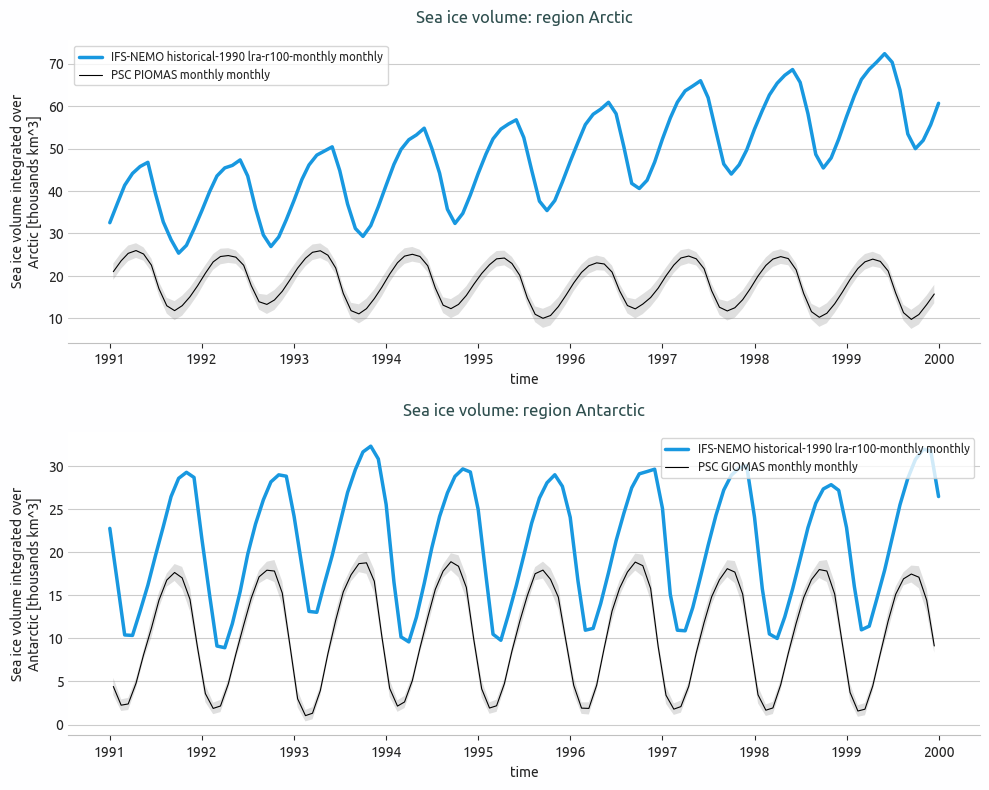

In [7]:
psi = PlotSeaIce(monthly_models=simod,
                 monthly_ref=[si_ref_nh, si_ref_sh],
                 monthly_std_ref=[si_std_ref_nh, si_std_ref_sh], 
                 outputdir='.',
                 rebuild=True,
                 loglevel=loglevel)
psi.plot_seaice(plot_type='timeseries', save_pdf=False, save_png=False)